# LLMs in Python with `transformers`

In [67]:
import transformers
import torch
import numpy as np
import seaborn as sns

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Lecture plan

- Review: **Large Language Models**.
- Introduction to the `transformers` package.
   - Tokenizers.
   - A "small" LLM.

## Review: LLMs

> **Large language models (LLMs)** are neural networks trained to predict the *next token*.

- LLMs use various architectures, from **recurrent neural networks** to **transformers**.
- So far, we've focused on the *theoretical underpinnings*, e.g., the **attention mechanism**.
- Now, we'll discuss (briefly) how to work with *pre-trained LLMs* in Python.

## The `transformers` package

> The [*huggingface* `transformers` package](https://huggingface.co/docs/transformers/en/index) is a Python package containing an API and tools to work with *pre-trained LLMs*.

- The package is named after the **transformer** architecture, one of the most popular LLM architectures.


### What is a pre-trained LLM?

> A **pre-trained LLM** is an LLM that has already been trained on a large corpus.

- Training LLMs is extremely costly.
- Thus, many researchers rely on *pre-trained* models, i.e., systems that dedicated research teams have already built.
- This has its own limitations (less freedom in how we train them), but does simplify the process.
- `transformers` has a bunch (>600K) of pre-trained models to work with.

### What do you need to know/use?

Suppose you want to use a model from `transformers` to calculate the *probability* of words in context. You'll need:

- A **tokenizer** for that model.
- The actual **pre-trained model**.

## Tokenizers!

> **Tokenization** is the process of *segmenting* a string into smaller chunks or units.

- We discussed a number of *tokenization* methods earlier this quarter.
- LLMs rely on their own **tokenizers**, which learn to segment text.
- A number of different *training procedures* for tokenization, such as [byte-pair encoding](https://huggingface.co/learn/llm-course/en/chapter6/5).
   - *tl;dr*: recursively learn longer and longer tokens by finding the most common substrings.
- Language models technically operate over *tokens* (IDs), not raw strings.

### Importing a tokenizer

- As illustration, we'll use the [*Pythia-160m* tokenizer](https://huggingface.co/EleutherAI/pythia-160m).
- *Pythia-160m* is part of a ["suite" of language models created by EleutherAI](https://arxiv.org/abs/2304.01373).
- To load a tokenizer, use:

```
AutoTokenizer.from_pretrained({MODEL_PATH})
```

In [3]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-160m")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Using a tokenizer

- To *use* a tokenizer, pass a `str` into the tokenizer object.
- This returns a dictionary with the **token IDs**.

In [4]:
phrase = "the person"
inputs = tokenizer(phrase, return_tensors="pt")
inputs

{'input_ids': tensor([[ 783, 1436]]), 'attention_mask': tensor([[1, 1]])}

#### What *are* these tokens anyway?

- Each *token* maps onto a specific *ID* in the model's vocabulary.
- Notice that some tokens start with a strange `"Ġ"` character. What do you think that is?

In [5]:
tokenizer.convert_ids_to_tokens(783)

'the'

In [6]:
### What do you think this Ġ represents?
tokenizer.convert_ids_to_tokens(1436)

'Ġperson'

#### Understanding tokens

- The `"Ġ"` character is the tokenizer's way of indicating that this token is a *new word*, i.e., it follows a whitespace (` `) character.
- Some tokens aren't separate words, they're just *part* of words!
- It all comes down to how the tokenizer **tokenizes** the word.

In [7]:
tokenizer("vanquish", return_tensors="pt")

{'input_ids': tensor([[6148,  371,  763]]), 'attention_mask': tensor([[1, 1, 1]])}

In [8]:
tokenizer.convert_ids_to_tokens(6148)

'van'

In [9]:
tokenizer.convert_ids_to_tokens(371)

'qu'

In [10]:
tokenizer.convert_ids_to_tokens(763)

'ish'

#### Check-in

Can you identify other words that are tokenized into multiple tokens?

In [11]:
### Your code here

### Tokenizing entire sentences

- You can tokenize entire sentences (or even multiple sentences).
- The only limitation (downstream) will be the size of the model's **context window**.

In [12]:
sentence = "The students enjoyed the class."
inputs = tokenizer(sentence, return_tensors="pt")

In [13]:
# What are the tokens?
tokens = [tokenizer.convert_ids_to_tokens(i) for i in inputs['input_ids']]
tokens

[['The', 'Ġstudents', 'Ġenjoyed', 'Ġthe', 'Ġclass', '.']]

## Language models

In `transformers`, the [`model`](https://huggingface.co/transformers/v3.0.2/main_classes/model.html) class can be used to:

- Calculate the **probability** of words in a sequence.
- Investigate the **hidden states** of a model.
- Investigate the **attention patterns** of a model.
- **Generate** new text by sampling from the model's probability distribution.

We'll explore examples of all these in turn!

### Instantiating a language model

- A pretrained model can be *instantiated* by passing in the HuggingFace path.
- `output_hidden_states = True` means we can inspect the model activations.

In [14]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-160m",
                                 output_hidden_states = True)
model

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 768)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-11): 12 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=768, out_features=2304, bias=True)
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=768, out_features=3072, bias=True)
          (dense_4h_to_h): Linear(in_features=3072, out_features=768, bias=True)
          

### Inspecting our model parameters

- An LM is fundamentally a bunch of **weight matrices**.
- Recall that each layer consists of a *transformer block*.
- We can directly access those weights (though it's hard to interpret them!).

In [15]:
### The QKV matrices for layer 2
model.gpt_neox.layers[1].attention.query_key_value

Linear(in_features=768, out_features=2304, bias=True)

In [16]:
### Actual weights
model.gpt_neox.layers[1].attention.query_key_value.weight

Parameter containing:
tensor([[ 4.6967e-02, -4.0970e-03, -1.2794e-02,  ..., -6.6284e-02,
         -1.6235e-02, -1.9302e-02],
        [ 5.0476e-02, -3.3203e-02, -1.2825e-02,  ..., -3.7415e-02,
         -1.1215e-02, -4.0192e-02],
        [-9.6359e-03,  5.3024e-03,  8.3008e-03,  ..., -6.0349e-03,
         -2.7252e-02, -8.1940e-03],
        ...,
        [ 1.7593e-02,  2.1515e-03,  2.9984e-03,  ..., -1.2329e-02,
         -2.5528e-02,  1.9958e-02],
        [ 1.9897e-02, -2.5940e-02,  5.7869e-03,  ..., -2.4902e-02,
          6.9351e-03,  7.2708e-03],
        [-1.4641e-02,  1.8723e-02,  9.0182e-05,  ...,  2.8763e-02,
         -1.4030e-02, -1.1425e-03]], requires_grad=True)

### Running the model

A pretrained model can be run in **inference mode**, i.e., without updating parameters.
- First, tokenize a sentence.
- Then, pass sentence into model.

In [17]:
### Tokenize sentence
sentence = "I like salt and"
inputs = tokenizer(sentence, return_tensors="pt")

In [18]:
### Pass into model
with torch.no_grad():
    output = model(**inputs, output_attentions = True,
                  return_dict = True)

### Inspecting our output

Given our output, we can inspect:

- The `logits`: useful for figuring out the *probability* assigned to particular words by the model.
- The `hidden_states`: useful for figuring out the *representation* of different tokens at each layer of the model.
- The `attention` weights: useful for figuring out where the model is "looking at".

In [19]:
### Logits for each token
output.logits.shape

torch.Size([1, 4, 50304])

In [20]:
### Hidden states for each token for each layer
print(output.hidden_states[0].shape)
print(output.hidden_states[1].shape)

torch.Size([1, 4, 768])
torch.Size([1, 4, 768])


In [21]:
### Attentions for each token/token for each layer/head
len(output.attentions)

12

### Inspecting the `logits`

- Technically, models allow sentences to be run in **batches**.
- We've only passed in one sentence, so we just have logits for that one sentence.
- The logits at each position represent the model's **predictions** at that token position.
- To access what word the model thinks is *most likely next*, we can look at the logits for the final position.

In [22]:
### Focus on sentence logits
sentence_logits = output.logits[0]
sentence_logits.shape

torch.Size([4, 50304])

In [23]:
### Last token logits
last_token_logits = sentence_logits[-1]
last_token_logits.shape

torch.Size([50304])

#### What word is most likely?

- Let's look at the top 5 predicted tokens using `torch.topk`.

*Check-in: How would we figure out which words those correspond to?*

In [24]:
top_k_values, top_k_indices = torch.topk(last_token_logits, 5)
top_k_indices

tensor([28140, 13835,  1824,   352,   309])

#### Decoding our tokens

- We can use `tokenizer.convert_ids_to_tokens` to figure out what those tokens actually are.

In [25]:
tokenizer.convert_ids_to_tokens(top_k_indices.tolist())

['Ġvinegar', 'Ġpepper', 'Ġwater', 'Ġit', 'ĠI']

#### Calculating the probability assigned to those tokens

- The **logits** are not equivalent to probability.
- We can *convert* logits to probability using the `softmax` operation.

In [26]:
last_token_probs = torch.softmax(last_token_logits, dim=0)
last_token_probs.sum() ### now they sum to 1

tensor(1.0000)

In [27]:
### Probability of those tokens
top_pred_prob = last_token_probs[top_k_indices]
top_pred_prob

tensor([0.1769, 0.1281, 0.0337, 0.0310, 0.0277])

In [28]:
### Reminder of what those tokens are...
tokenizer.convert_ids_to_tokens(top_k_indices.tolist())

['Ġvinegar', 'Ġpepper', 'Ġwater', 'Ġit', 'ĠI']

#### Calculating the probability of *specific tokens*

- Often, we don't just want to know what word comes next.
- We might want to know the probability assigned to *specific tokens* at a *specific position*.
- For that, we can use this handy function I've written called `next_seq_prob`.

In [29]:
def next_seq_prob(model, tokenizer, seen, unseen):
    """Get p(unseen | seen)

    Parameters
    ----------
    model : transformers.PreTrainedModel
        Model to use for predicting tokens
    tokenizer : transformers.PreTrainedTokenizer
        Tokenizer for Model
    seen : str
        Input sequence
    unseen: str
        The sequence for which to calculate a probability
    """
    # Get ids for tokens
    input_ids = tokenizer.encode(seen, return_tensors="pt")
    unseen_ids = tokenizer.encode(unseen)

    # Loop through unseen tokens & store log probs
    log_probs = []
    for unseen_id in unseen_ids:

        # Run model on input
        with torch.no_grad():
            logits = model(input_ids).logits

        # Get next token prediction logits
        next_token_logits = logits[0, -1]
        next_token_probs = torch.softmax(next_token_logits, 0) # Normalize

        # Get probability for relevant token in unseen string & store
        prob = next_token_probs[unseen_id]
        log_probs.append(torch.log(prob))

        # Add input tokens incrementally to input
        input_ids = torch.cat((input_ids, torch.tensor([[unseen_id]])), 1)

    # Add log probs together to get total log probability of sequence
    total_log_prob = sum(log_probs)
    # Exponentiate to return to probabilities
    total_prob = torch.exp(total_log_prob)
    return total_prob.item()

#### Using our `next_seq_prob` function

In [30]:
### cats and...dogs
next_seq_prob(model, tokenizer, "I like cats and", " dogs")

0.2902168035507202

In [31]:
### cats and...lizards
next_seq_prob(model, tokenizer, "I like cats and", " lizards")

0.00196227990090847

#### Check-in

Try to identify other words that would be either *likely* or *unlikely* in this context.

In [32]:
### Your code here

#### Probability vs. surprisal

> **Surprisal** is the negative log probability of a word in context.

- Researchers often use *surprisal* instead of *raw probability*.
- A higher surprisal score means the model assigned *lower probability* to that word.

In [33]:
def surprisal(x):
    return -np.log(x)

In [34]:
surprisal(.02)

3.912023005428146

In [35]:
surprisal(.9)

0.10536051565782628

#### Surprisal in action

- Researchers often compare the surprisal of an *expected* vs. *unexpected* token.
- *Example*: sensitivity to *grammatical* vs. *ungrammatical* sentences.

In [36]:
### Grammatical
surprisal(next_seq_prob(model, tokenizer, "The keys", " are"))

1.458002945185585

In [37]:
### Ungrammatical
surprisal(next_seq_prob(model, tokenizer, "The keys", " is"))

5.236811674957567

#### Check-in

Can you create a list of grammatical vs. ungrammatical sentences using **subject-verb agreement** (i.e., singular noun, singular verb; or plural noun, plural verb), and test for sensitivity this distinction?

In [38]:
### Your code here

#### Probability all the way down

- With careful **experimental design**, you can use *surprisal* as an index into what an LM knows and doesn't know.
- Many examples:
   - Grammatical vs. ungrammatical sentences. 
   - Plausible vs. implausible scenarios.
   - True vs. false beliefs (e.g., Theory of Mind).
   - Correct vs. incorrect answer (e.g., on a test).

Can you think of any others?

### Inspecting the `hidden_states`

> The **hidden states** are vectors of "activations" for each token of each layer of the model.

- Our model has *12* layers, plus the initial embedding layer.
- This particular model has a $768$-D vector for each token at each layer.

In [39]:
print("Sentence: " + sentence)
print("Token IDs:", inputs['input_ids'])

Sentence: I like salt and
Token IDs: tensor([[  42,  751, 7043,  285]])


In [40]:
### Hidden states for each layer
len(output.hidden_states)

13

In [41]:
### Size of hidden state at each layer
output.hidden_states[3].shape

torch.Size([1, 4, 768])

#### Comparing hidden states (1)

One way to demonstrate the **hidden state activations** is to compare the representations for the same *word* in different contexts.

In [42]:
### Tokenize phrases
c1 = tokenizer("marinated lamb", return_tensors="pt")
c2 = tokenizer("roasted lamb", return_tensors="pt")
c3 = tokenizer("friendly lamb",  return_tensors="pt")

In [43]:
### Run through model
with torch.no_grad():
    o1 = model(**c1)
    o2 = model(**c2)
    o3 = model(**c3)

#### Comparing hidden states (2)

One way to demonstrate the **hidden state activations** is to compare the representations for the same *word* in different contexts.

In [44]:
from scipy.spatial.distance import cosine

In [45]:
### Last layer, first batch, last token
e1 = o1.hidden_states[12][0][-1]
e2 = o2.hidden_states[12][0][-1]
e3 = o3.hidden_states[12][0][-1]

In [46]:
cosine(e1, e2)

0.00295881561174427

In [47]:
cosine(e1, e3)

0.004162431863919069

In [48]:
cosine(e2, e3)

0.004779704677303598

### Inspecting the `attentions`

> The **attention scores** are vectors of *attention* from each token to every other token, for each head in each model layer.

In [53]:
### Attention for layer 1:
output.attentions[1].shape

torch.Size([1, 12, 4, 4])

#### Plotting the attention distribution

Let's zoom in on the attention for a specific **head/layer**.

In [84]:
layer_idx, head_idx = 3, 1
attn_matrix = output.attentions[layer_idx][0, head_idx]
attn_matrix.shape

torch.Size([4, 4])

<Axes: >

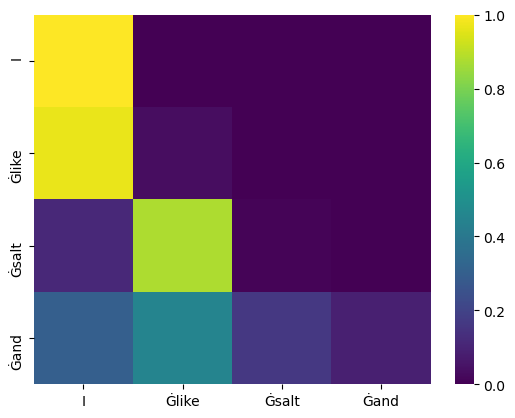

In [85]:
### Tokens to plot
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
sns.heatmap(attn_matrix.cpu().detach().numpy(),
            xticklabels=tokens,
            yticklabels=tokens,
            cmap="viridis")

### Generating text!

- Finally, we can use the `generate` function to *sample* new tokens.
- `max_length`: maximum number of tokens to generate.
- By default, `generate` will use **greedy search** (selecting the most likely token).

In [100]:
gen_output = model.generate(**inputs, max_length=40)
gen_output

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


tensor([[   42,   751,  7043,   285, 28140,    15,   309,  1353,   417,   247,
          1943,  7989,   273, 28140,    13,   533,   309,   751,   352,    15,
           309,   751,   352,   672,   352,   434,  5352,   285,   352,   434,
           417,  1512,  3779,   555,    15,   309,   751,   352,   672,   352]])

In [101]:
tokenizer.decode(gen_output[0], skip_special_tokens=True)

"I like salt and vinegar. I'm not a big fan of vinegar, but I like it. I like it when it's fresh and it's not too salty. I like it when it"

#### Other generation strategies

- **Sampling**: rather than selecting the *most likely* token, we sample randomly (weighted by the underlying probability).
- **Beam search**: maintain multiple possible strings/branches, then select the one with the highest overall probability.

See [HuggingFace's documentation on generation strategies](https://huggingface.co/docs/transformers/en/generation_strategies) for more details.

In [104]:
gen_output = model.generate(**inputs, max_length=40, 
                            do_sample = True,
                           temperature = .7)
gen_output

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


tensor([[   42,   751,  7043,   285, 28140,    15,   313,  2512,   403,   690,
          5053,    13,   533,   352,  7024,   327,   849,   368,   751,   352,
            10,   187,   187,    42,   717,   970,   253,  1563,  2746,    27,
           187,   187,    42,   717,   970,   247,  2505,  8121,   326,   556]])

In [105]:
tokenizer.decode(gen_output[0], skip_special_tokens=True)

'I like salt and vinegar. (There are some places, but it depends on how you like it)\n\nI am using the following approach:\n\nI am using a text editor that has'

## Lecture wrap-up

- The `transformers` library is incredibly powerful.
- It's also (relatively) straightforward to use, given how powerful it is!
- In terms of *using* models, you'll probably want to do one of the following:
   - Access `logits`.
   - Access `hidden_states`.
   - Inspect `attentions`.
   - `generate` more text.
- Additional **use cases** would include *training* or *fine-tuning* models.
- Hopefully you now feel more confident importing and using LLMs!